In [1]:
from IPython.display import clear_output

!wget -O event_log.csv https://www.dropbox.com/scl/fi/8cedizozqtsnwt6p5m7wa/finale.csv?rlkey=2hnsbp7am42yz8w1dai8ii06w&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pd.read_csv('event_log.csv', sep = ',')

log_format = {'case:concept:name': 'Case ID',
              'concept:name': 'Activity',
              'time:timestamp': 'Complete Timestamp',
              'start_timestamp': '',
              'org:resource': 'Resource',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 4580
Variant count: 226
Event count: 21348
Activity count: 14


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 19.909914 seconds.


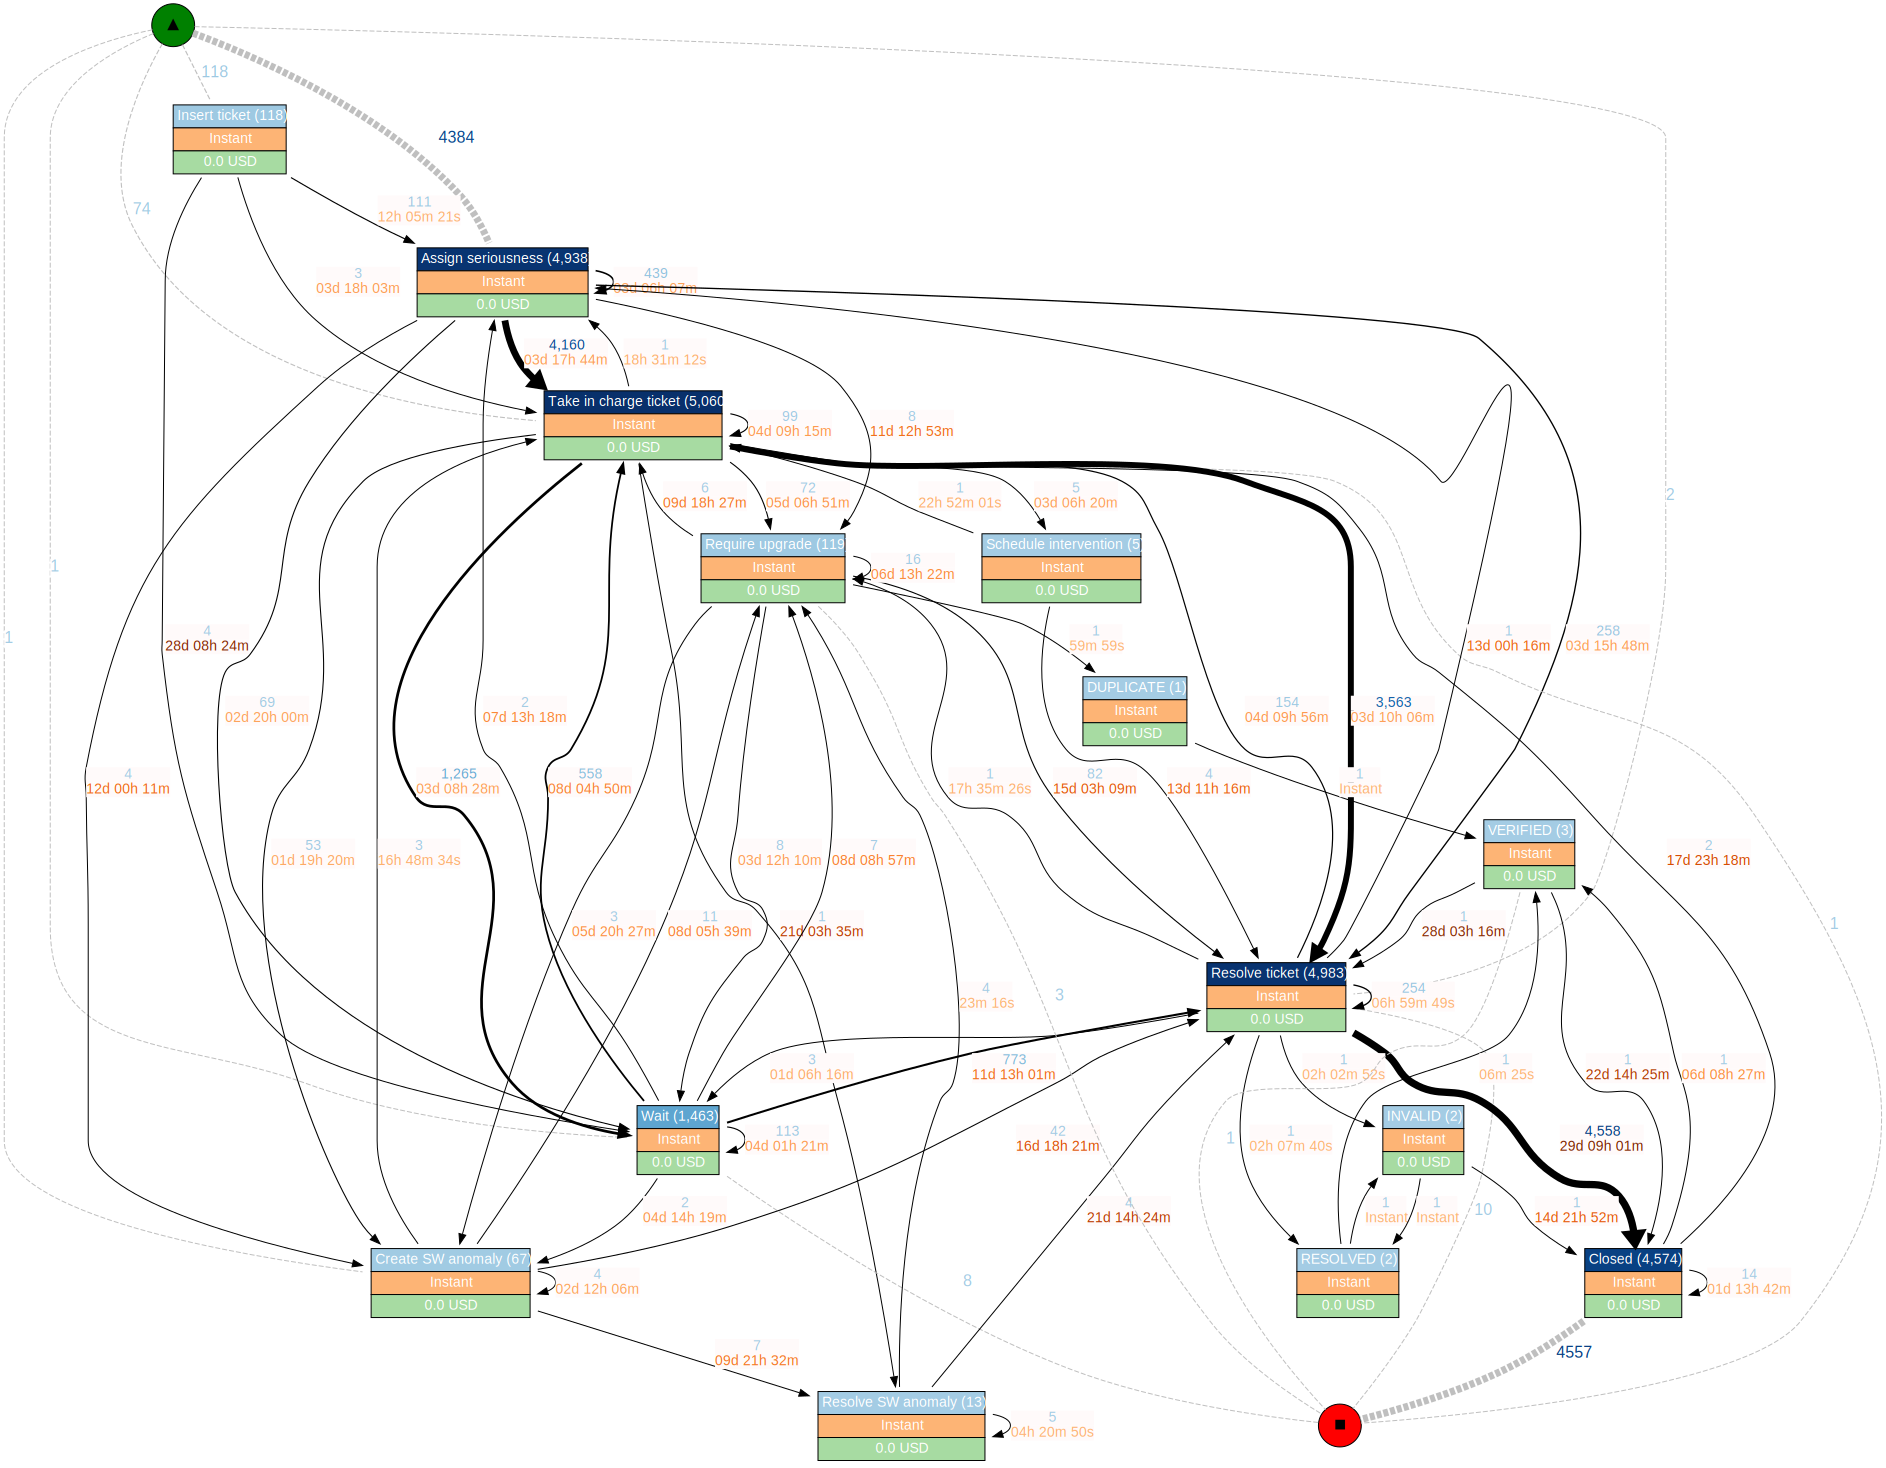

MP-DFG visualization time: 0.356883 seconds.


In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 4580/4580 [00:17<00:00, 268.25it/s]


Calculating log metrics: 


100%|██████████| 4580/4580 [00:14<00:00, 320.77it/s]


Building Tree Cases:


100%|██████████| 4580/4580 [00:14<00:00, 314.69it/s]


Building Tree Graph:


100%|██████████| 4580/4580 [00:00<00:00, 13115.36it/s]

MD-DRT discovery time: 46.445188 seconds.


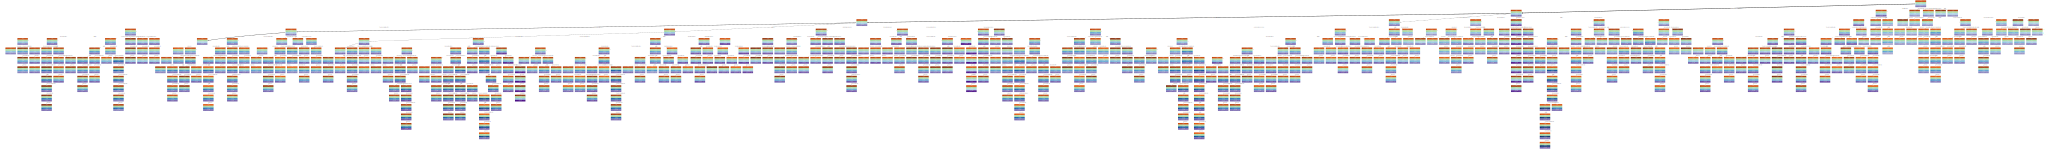

MD-DRT visualization time: 1.565545 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 19.909914 seconds.
MP-DFG visualization time: 0.356883 seconds.
MD-DRT discovery time: 46.445188 seconds.
MD-DRT visualization time: 1.565545 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# Some activities occur only 1-3 times and seem to be input errors
# Cases containing these activities are removed, as their inclusion increments the complexity of the process models without providing additional insights
processed_log = pm4py.filter_event_attribute_values(processed_log, 'concept:name', ['DUPLICATE', 'INVALID', 'RESOLVED', 'VERIFIED'], level = 'case', retain = False)

# Moreover, the original log contains some cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that start with 'Assign seriousness', 'Insert ticket', or 'Take in charge ticket', and that end with 'Closed' or 'Resolve ticket' will be considered
processed_log = pm4py.filter_start_activities(processed_log, ['Assign seriousness', 'Insert ticket', 'Take in charge ticket'])
processed_log = pm4py.filter_end_activities(processed_log, ['Closed', 'Resolve ticket'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 4580
Case count after: 4561


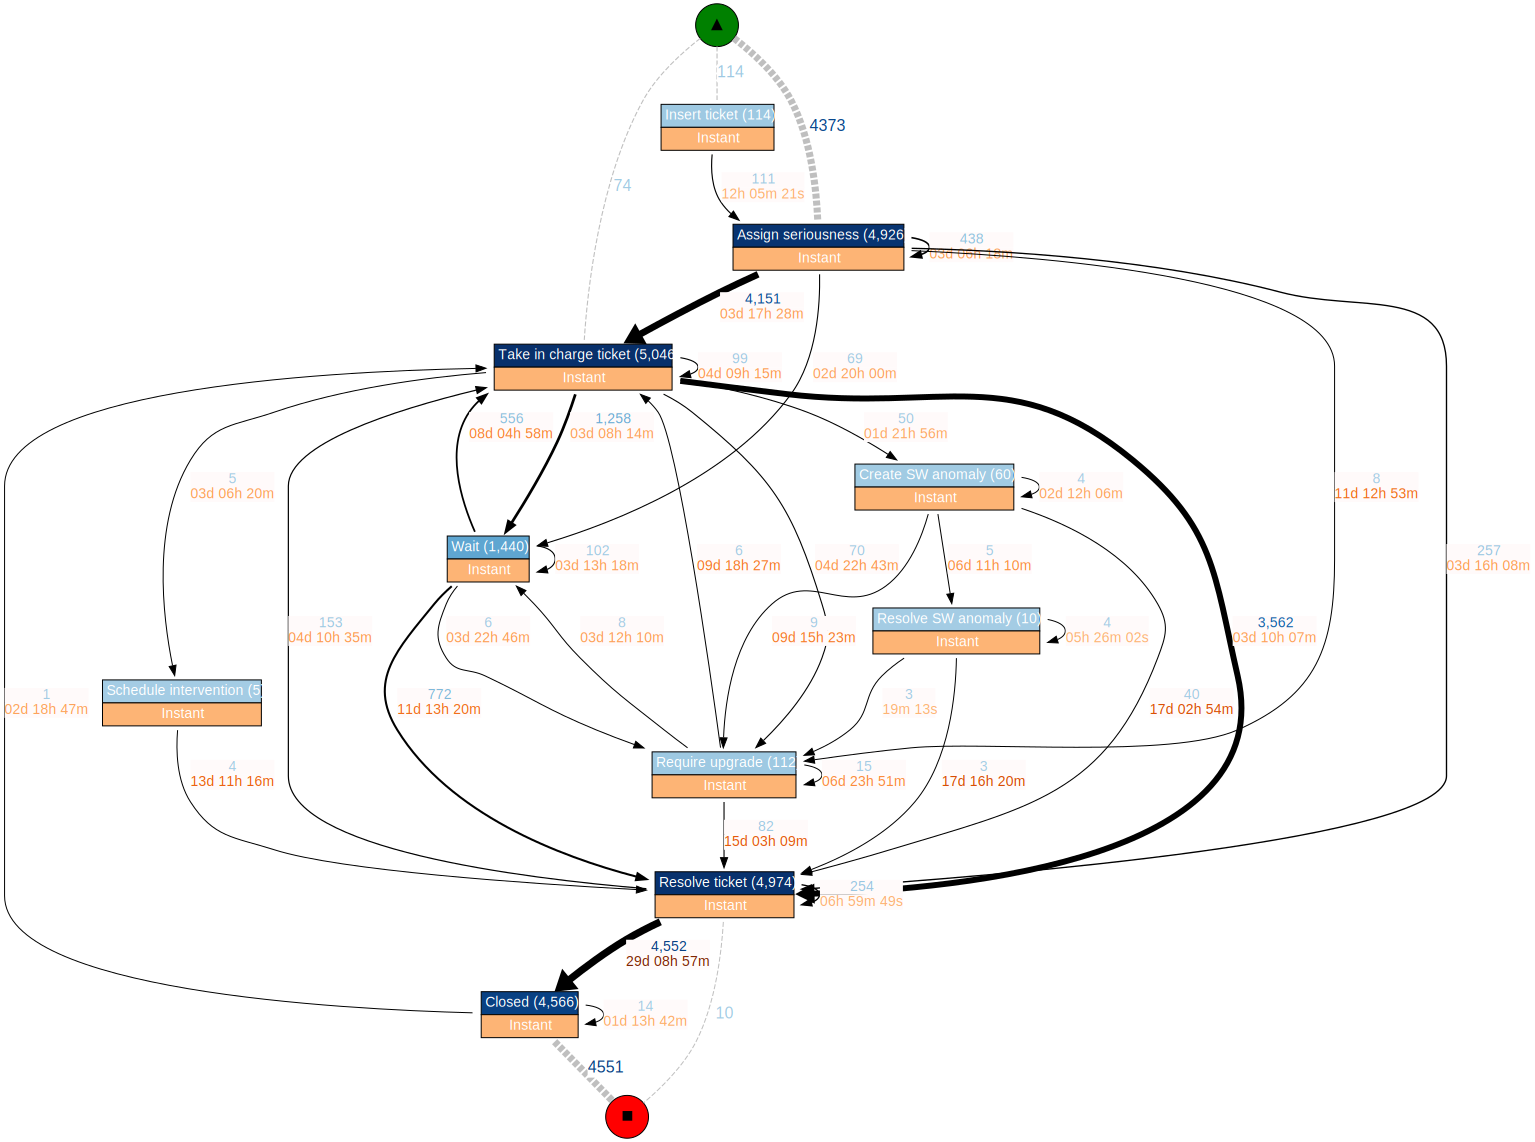

In [13]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

# The frequency of many paths is not high, so only the most common ones are considered
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(65, dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_processed_log_100_65', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_100_65.svg'))

Calculating log mandatory activities: 


100%|██████████| 4540/4540 [00:12<00:00, 368.53it/s]


Calculating log metrics: 


100%|██████████| 4540/4540 [00:13<00:00, 324.74it/s]


Building Tree Cases:


100%|██████████| 4540/4540 [00:14<00:00, 310.16it/s]


Building Tree Graph:


100%|██████████| 4540/4540 [00:00<00:00, 13358.70it/s]


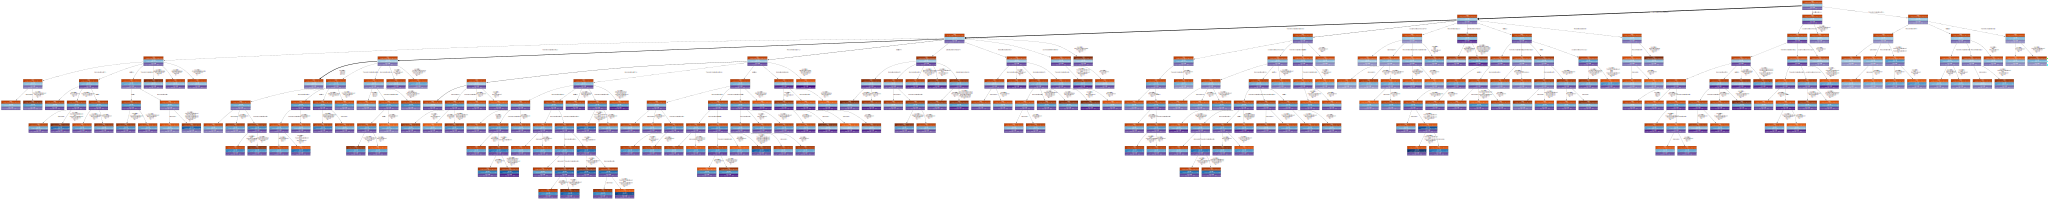

In [14]:
# Since some variants of the process rarely occur (i.e., less than 16 times), only the 90% most common variants are considered
pruned_log = mpvis.preprocessing.prune_log_based_on_top_variants(processed_log.copy(), k = 188)

# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(pruned_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_autogroup_90_variants', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_autogroup_90_variants.svg'))